In [3]:
import tensorflow as tf
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#### Loading Data

In [ ]:
# tf.keras.utils.image_dataset_from_directory??

In [5]:
# Building a data pipeline and also preprocessing image data
dataset = tf.keras.utils.image_dataset_from_directory('brain_tumor_dataset') # 1 -> Tumor 0 -> No Tumor
data_iterator = dataset.as_numpy_iterator()
batch = data_iterator.next() # Each batch is of size 32


Found 253 files belonging to 2 classes.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-18 16:07:00.669723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-18 16:07:00.670072: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-18 16:07:00.840771: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


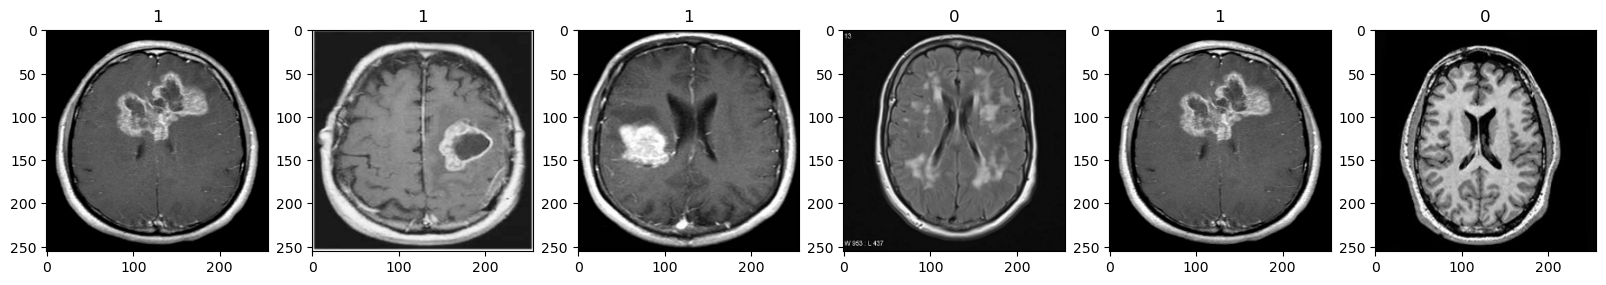

In [6]:
fig, ax = plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#### Preprocessing

In [7]:
""" 
    Scaling data
        Since RGB values range from 0 to 255, scaling them to be between 0 and 1
"""

dataset = dataset.map(lambda x,y: (x/255, y))
scaled_itr = dataset.as_numpy_iterator()
b = scaled_itr.next()



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


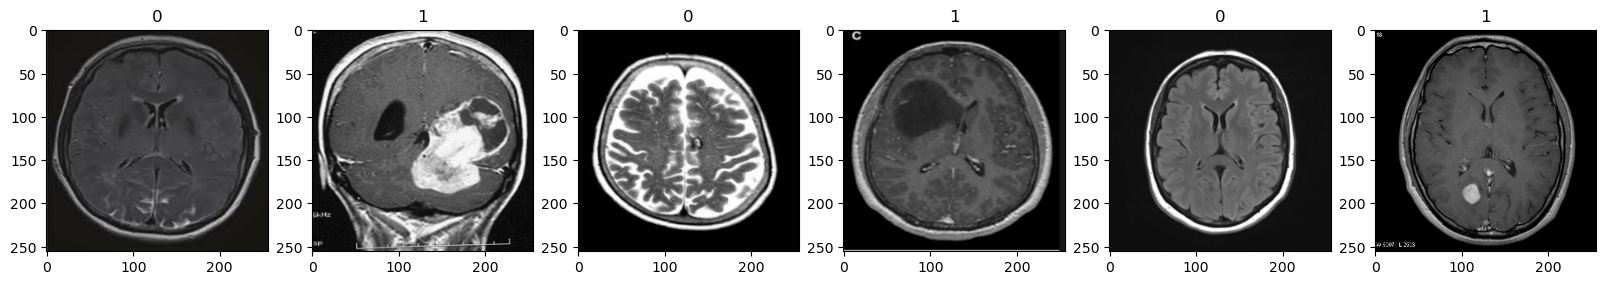

In [8]:
fig, ax = plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(b[0][:6]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(b[1][idx])

In [9]:
"""
    Splitting data for training, testing and validation
    
    Number of batches = 8

    70% Training
    10% Testing
    20% Validation
"""

train_s = int(len(dataset)* 0.7)
test_s = int(len(dataset)*0.1) + 1
val_s = int(len(dataset)*0.2) + 1


train = dataset.take(train_s)
val = dataset.skip(train_s).take(val_s)
test = dataset.skip(train_s + val_s).take(test_s)

In [10]:
# train_features = []
# train_labels = []
x_train = []
y_train = []
for images, labels in train:
    features = tf.keras.applications.resnet50.preprocess_input(images)
    x_train.append(features)
    y_train.append(labels)
x_train = np.concatenate(x_train)
x_train = x_train.reshape(x_train.shape[0], -1)
y_train = np.concatenate(y_train)

# test_features = []
# test_labels = []
x_test = []
y_test = []
for images, labels in test:
    features = tf.keras.applications.resnet50.preprocess_input(images)
    x_test.append(features)
    y_test.append(labels)
x_test = np.concatenate(x_test)
x_test = x_test.reshape(x_test.shape[0], -1)
y_test = np.concatenate(y_test)

## Models

### CNN

In [11]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape=(256,256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1 ,  activation = 'sigmoid'))

In [12]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

#### Training the Model

In [13]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
model_fit = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15


2023-03-18 16:07:30.677712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-18 16:07:31.119197: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x161d7ea60
2023-03-18 16:07:31.119235: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x161d7ea60
2023-03-18 16:07:31.127456: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x161d7ea60
2023-03-18 16:07:31.127483: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x161d7ea60
2023-03-18 16:07:31.142440: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/0k/33xc23rd39v28fxtr5xb2gbh0000gn/T/ipykernel_11122/2925264490.py", line 3, in <module>
      model_fit = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x161d7ea60
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_1520]

#### Performance

In [ ]:
model_fit.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

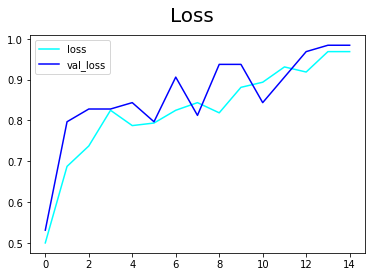

In [ ]:
fig = plt.figure()
plt.plot(model_fit.history['accuracy'], color = 'cyan', label = 'loss')
plt.plot(model_fit.history['val_accuracy'], color = 'blue', label = 'val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

#### Model Evaluation

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  x, y = batch
  y_pred = model.predict(x)
  pre.update_state(y, y_pred)
  re.update_state(y, y_pred)
  acc.update_state(y, y_pred)

print(f'Precision:{pre.result().numpy()}, Reacll: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

1/1 [==============================] - 1s 566ms/step
Precision:1.0, Reacll: 0.9444444179534912, Accuracy: 0.9655172228813171


In [ ]:
"""
  Testing the model with images that it hasn't seen

"""

image = cv2.imread('/content/contentdrive/MyDrive/Data/brain_tumor_dataset/yes/Y1.jpg') # Change the image that is being used to testing later
resize = tf.image.resize(image, (256, 256))
y_pred = model.predict(np.expand_dims(resize/255, 0))
print(f'Actual Value: {y_pred}')

# Classification
yes = "Tumor present"
no = "Tumor absent"
output = yes if y_pred >= 0.5 else no
print(output)


1/1 [==============================] - 0s 203ms/step
Actual Value: [[0.99709994]]
Tumor present


##### **For every model from here, make a plot using staged_predict**

### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
score = knn.score(x_train, y_train)
print(f'Test accuracy: {score:.4f}')



Test accuracy: 0.8000


In [ ]:
y_pred = knn.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7586206896551724
Precision: 0.9473684210526315
Recall: 0.75
F1-score: 0.8372093023255814


#### Hyperparameter optimization

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)

Best hyperparameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Best accuracy score: 0.78125


### SVM

In [ ]:
svm = SVC(kernel='linear')

# Train the classifier on the training data
svm.fit(x_train, y_train)

# Make predictions on the testing data
y_pred = svm.predict(x_test)

# Evaluate the classifier using binary classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9655172413793104
Precision: 1.0
Recall: 0.9583333333333334
F1-score: 0.9787234042553191


#### Hyperparameter Optimization

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 
              'kernel': ['linear', 'rbf', 'poly'], 
              'degree': [2, 3, 4], 
              'gamma': ['scale', 'auto']}

clf = SVC()
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(x_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
y_pred = grid_search.predict(x_test)
print("Best accuracy score:", grid_search.best_score_)
print(classification_report(y_test, y_pred))

### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)


rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

#### Hyperparameter Optimization

In [ ]:
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [None, 10, 50, 100],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2']}

clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(x_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)
print("Best accuracy score:", grid_search.best_score_)

y_pred = grid_search.predict(x_test)

print(classification_report(y_test, y_pred))